In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import yfinance as yf

In [61]:
# Define the ticker symbol for Apple
ticker = 'AAPL'
data = yf.download(ticker, start="2020-01-01", )
data.columns = data.columns.get_level_values(0)
print(data.shape)

[*********************100%***********************]  1 of 1 completed

(1236, 6)


### Compute weights

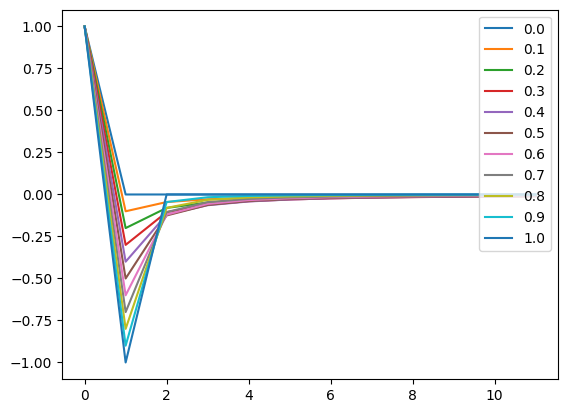

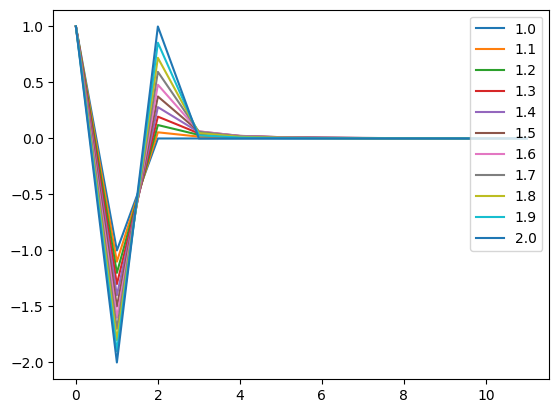

In [2]:
def getWeights(d, size):
    # thres > 0 drops insignificant weights
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1]/k * (d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w

def plotWeights(dRange, nPlots, size):
    w = pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        d = d.round(1)
        w_ = getWeights(d, size=size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
    ax = w.plot()
    ax.legend(fontsize=10, loc='upper right')
    plt.show()
    return

#----------------------------------------
if __name__ == '__main__':
    plotWeights(dRange=[0,1], nPlots=11, size=12)
    plotWeights(dRange=[1,2], nPlots=11, size=12)

### Standard FracDiff (Expanding Window)

In [3]:
def fracDiff(series, d, thres=.01):
    '''
    Increase width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped
    Note 2: d can be any positive fractional, not necessarily bounded [0,1]
    '''
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].ffill().dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isfinite(series.loc[loc, name]):
                continue #exclude NAs
            df_[loc] = np.dot(w[-(iloc+1):, :].T, seriesF.loc[:loc])[0,0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [59]:
data_frac = fracDiff(data, d=.4, thres=.05)
data_frac.shape

(1182, 6)

In [ ]:
def two_in_1(frac_df, df, figsize=(12, 6)):
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=figsize)
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('FracDiff Close', color=color)
    ax1.plot(frac_df, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Close', color=color)  # we already handled the x-label with ax1
    ax2.plot(df, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

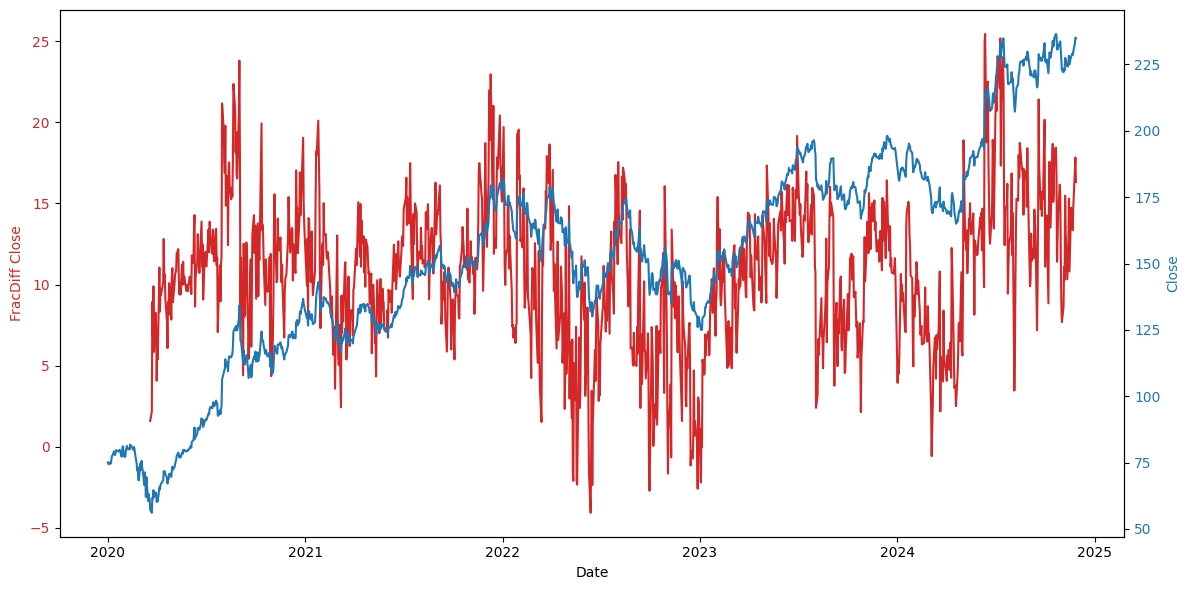

In [46]:
two_in_1(data_frac['Close'], data['Close'])

### Fixed-Width Window Fracdiff

In [27]:
def getWeights_FFD(d, thres=1e-5):
    w=[1.]
    if thres <= 0:
        print("Threshold must be positive, set to 1e-5")
        thres = 1e-5
    k = 1
    while abs(w[-1]) >= thres:
        w_ = -w[-1]/k*(d-k+1) 
        k += 1
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w


In [40]:
def fracDiff_FFD(series, d, thres=1e-5):
    w = getWeights_FFD(d, thres)
    width = len(w) - 1
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].ffill().dropna(), pd.Series()
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue # exclude NAs
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [58]:
data_frac_FFD = fracDiff_FFD(data, d=0.4, thres=0.0001)
data_frac_FFD.shape

(954, 6)

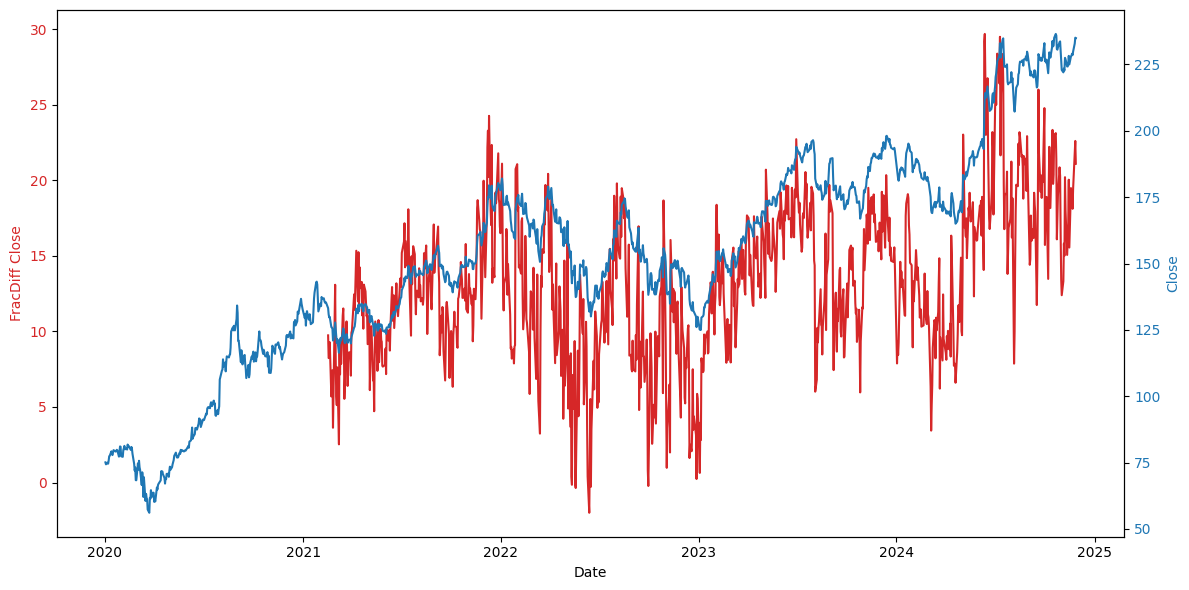

In [60]:
two_in_1(data_frac_FFD['Close'], data['Close'])